# Лабораторная работа №5: Проведение исследований с градиентным бустингом

## Цель работы
Исследование алгоритмов GradientBoostingClassifier (для классификации) и GradientBoostingRegressor (для регрессии), сравнение с бейзлайном и улучшенными моделями, а также итоговое сравнение всех алгоритмов из лабораторных работ 1-5.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, f1_score, classification_report, mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)



# Создание бейзлайна и оценка качества

## Подготовка данных для классификации


In [2]:
df_classification = pd.read_csv('adult.csv')

X_clf = df_classification.drop('income', axis=1)
y_clf = df_classification['income']

X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

print(f"Размер обучающей выборки: {X_clf_train.shape}")
print(f"Размер тестовой выборки: {X_clf_test.shape}")



Размер обучающей выборки: (26048, 14)
Размер тестовой выборки: (6513, 14)


## Предобработка данных для классификации(LabelEncoder, масштабирование признаков, замена пропущенных значений)

In [3]:
numeric_cols_clf = X_clf_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols_clf = X_clf_train.select_dtypes(include=['object']).columns.tolist()

print("Числовые признаки:", numeric_cols_clf)
print("Категориальные признаки:", categorical_cols_clf)

label_encoders_clf = {}
X_clf_train_encoded = X_clf_train.copy()
X_clf_test_encoded = X_clf_test.copy()

for col in categorical_cols_clf:
    le = LabelEncoder()
    X_clf_train_encoded[col] = X_clf_train_encoded[col].replace('?', 'Unknown')
    X_clf_test_encoded[col] = X_clf_test_encoded[col].replace('?', 'Unknown')
    X_clf_train_encoded[col] = le.fit_transform(X_clf_train_encoded[col].astype(str))
    X_clf_test_encoded[col] = le.fit_transform(X_clf_test_encoded[col].astype(str))
    label_encoders_clf[col] = le

scaler_clf = StandardScaler()
X_clf_train_scaled = X_clf_train_encoded.copy()
X_clf_test_scaled = X_clf_test_encoded.copy()

X_clf_train_scaled[numeric_cols_clf] = scaler_clf.fit_transform(X_clf_train_encoded[numeric_cols_clf])
X_clf_test_scaled[numeric_cols_clf] = scaler_clf.transform(X_clf_test_encoded[numeric_cols_clf])



Числовые признаки: ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
Категориальные признаки: ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']


##  Обучение модели классификации (бейзлайн)


In [4]:
gb_clf_baseline = GradientBoostingClassifier(random_state=42, n_estimators=100)

gb_clf_baseline.fit(X_clf_train_scaled, y_clf_train)

y_clf_pred_baseline = gb_clf_baseline.predict(X_clf_test_scaled)



## Оценка качества модели классификации по выбранным метрикам

In [5]:
accuracy_clf_baseline = accuracy_score(y_clf_test, y_clf_pred_baseline)
f1_clf_baseline = f1_score(y_clf_test, y_clf_pred_baseline, pos_label='>50K')

print("Результаты бейзлайн модели для классификации:")
print(f"Accuracy: {accuracy_clf_baseline:.4f}")
print(f"F1-score: {f1_clf_baseline:.4f}")
print("\nПодробный отчет по классификации:")
print(classification_report(y_clf_test, y_clf_pred_baseline))

Результаты бейзлайн модели для классификации:
Accuracy: 0.8598
F1-score: 0.6705

Подробный отчет по классификации:
              precision    recall  f1-score   support

       <=50K       0.88      0.94      0.91      4945
        >50K       0.77      0.59      0.67      1568

    accuracy                           0.86      6513
   macro avg       0.83      0.77      0.79      6513
weighted avg       0.85      0.86      0.85      6513



## Подготовка данных для регрессии


In [6]:
df_train_regression = pd.read_csv('train_data.csv')
df_test_regression = pd.read_csv('test_data.csv')

X_reg_train = df_train_regression.drop('age', axis=1)
y_reg_train = df_train_regression['age']

X_reg_test = df_test_regression.drop('age', axis=1)
y_reg_test = df_test_regression['age']

print(f"Размер обучающей выборки: {X_reg_train.shape}")
print(f"Размер тестовой выборки: {X_reg_test.shape}")



Размер обучающей выборки: (4398, 12)
Размер тестовой выборки: (1100, 12)


## Предобработка данных для регрессии (делаю тоже самое что и для классификации

In [7]:
numeric_cols_reg = X_reg_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols_reg = X_reg_train.select_dtypes(include=['object']).columns.tolist()

print("Числовые признаки:", numeric_cols_reg)
print("Категориальные признаки:", categorical_cols_reg)

label_encoders_reg = {}
X_reg_train_encoded = X_reg_train.copy()
X_reg_test_encoded = X_reg_test.copy()

for col in categorical_cols_reg:
    le = LabelEncoder()
    X_reg_train_encoded[col] = X_reg_train_encoded[col].fillna('Unknown')
    X_reg_test_encoded[col] = X_reg_test_encoded[col].fillna('Unknown')
    X_reg_train_encoded[col] = le.fit_transform(X_reg_train_encoded[col].astype(str))
    X_reg_test_encoded[col] = le.fit_transform(X_reg_test_encoded[col].astype(str))
    label_encoders_reg[col] = le

scaler_reg = StandardScaler()
X_reg_train_scaled = X_reg_train_encoded.copy()
X_reg_test_scaled = X_reg_test_encoded.copy()

X_reg_train_scaled[numeric_cols_reg] = scaler_reg.fit_transform(X_reg_train_encoded[numeric_cols_reg])
X_reg_test_scaled[numeric_cols_reg] = scaler_reg.transform(X_reg_test_encoded[numeric_cols_reg])



Числовые признаки: ['uranium_lead_ratio', 'carbon_14_ratio', 'radioactive_decay_series', 'stratigraphic_layer_depth', 'isotopic_composition', 'fossil_size', 'fossil_weight']
Категориальные признаки: ['geological_period', 'paleomagnetic_data', 'surrounding_rock_type', 'stratigraphic_position']


## Обучение модели регрессии (бейзлайн)


In [8]:
gb_reg_baseline = GradientBoostingRegressor()

gb_reg_baseline.fit(X_reg_train_scaled, y_reg_train)

y_reg_pred_baseline = gb_reg_baseline.predict(X_reg_test_scaled)

## Оценка качества модели классификации по выбранным метрикам

In [9]:
mse_reg_baseline = mean_squared_error(y_reg_test, y_reg_pred_baseline)
mae_reg_baseline = mean_absolute_error(y_reg_test, y_reg_pred_baseline)
r2_reg_baseline = r2_score(y_reg_test, y_reg_pred_baseline)

print("Результаты бейзлайн модели для регрессии:")
print(f"MSE: {mse_reg_baseline:.2f}")
print(f"MAE: {mae_reg_baseline:.2f}")
print(f"R²: {r2_reg_baseline:.4f}")
print(f"RMSE (корень из MSE): {np.sqrt(mse_reg_baseline):.2f}")



Результаты бейзлайн модели для регрессии:
MSE: 3438844.96
MAE: 1409.51
R²: 0.9858
RMSE (корень из MSE): 1854.41


# Улучшение бейзлайна

## Формулирование гипотез для улучшения

### Гипотезы для улучшения качества моделей:

1. **Препроцессинг данных:**
   - Обработка пропусков значений
   - Нормализация/стандартизация признаков (уже применена)
   - Обработка выбросов

2. **Визуализация данных:**
   - Анализ распределений признаков
   - Корреляционный анализ
   - Анализ важности признаков

3. **Формирование новых признаков:**
   - Создание комбинаций признаков
   - Полиномиальные признаки
   - Взаимодействия признаков

4. **Подбор гиперпараметров:**
   - Для логистической регрессии: регуляризация (L1/L2), коэффициент регуляризации (C)
   - Для линейной регрессии: регуляризация (Ridge, Lasso, ElasticNet)
   - Использование кросс-валидации для выбора параметров


## Проверка гипотез - Препроцессинг данных

### Обработка выбросов для классификации


In [10]:
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data < lower_bound) | (data > upper_bound)

outliers_info = {}
for col in numeric_cols_clf:
    outliers = detect_outliers_iqr(X_clf_train[col])
    outliers_info[col] = outliers.sum()
    print(f"{col}: {outliers.sum()} выбросов ({outliers.sum()/len(X_clf_train)*100:.2f}%)")

X_clf_train_no_outliers = X_clf_train_encoded.copy()
X_clf_test_no_outliers = X_clf_test_encoded.copy()

for col in numeric_cols_clf:
    if outliers_info[col] > len(X_clf_train) * 0.05:
        Q1 = X_clf_train[col].quantile(0.25)
        Q3 = X_clf_train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        X_clf_train_no_outliers[col] = X_clf_train_no_outliers[col].clip(lower=lower_bound, upper=upper_bound)
        X_clf_test_no_outliers[col] = X_clf_test_no_outliers[col].clip(lower=lower_bound, upper=upper_bound)

scaler_clf_no_out = StandardScaler()
X_clf_train_no_out_scaled = X_clf_train_no_outliers.copy()
X_clf_test_no_out_scaled = X_clf_test_no_outliers.copy()

X_clf_train_no_out_scaled[numeric_cols_clf] = scaler_clf_no_out.fit_transform(X_clf_train_no_outliers[numeric_cols_clf])
X_clf_test_no_out_scaled[numeric_cols_clf] = scaler_clf_no_out.transform(X_clf_test_no_outliers[numeric_cols_clf])

age: 200 выбросов (0.77%)
fnlwgt: 774 выбросов (2.97%)
education.num: 967 выбросов (3.71%)
capital.gain: 2179 выбросов (8.37%)
capital.loss: 1232 выбросов (4.73%)
hours.per.week: 7199 выбросов (27.64%)


## Результаты модели с обработкой выбросов

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

model_clf_no_outliers = GradientBoostingClassifier(random_state=42)
model_clf_no_outliers.fit(X_clf_train_no_out_scaled, y_clf_train)
y_clf_pred_no_outliers = model_clf_no_outliers.predict(X_clf_test_no_out_scaled)

accuracy_clf_no_outliers = accuracy_score(y_clf_test, y_clf_pred_no_outliers)
f1_clf_no_outliers = f1_score(y_clf_test, y_clf_pred_no_outliers, pos_label='>50K')

print("Результаты модели с обработкой выбросов:")
print(f"Accuracy: {accuracy_clf_no_outliers:.4f}")
print(f"F1-score: {f1_clf_no_outliers:.4f}")
print(f"\nСравнение с бейзлайном:")
print(f"Accuracy: {accuracy_clf_baseline:.4f} -> {accuracy_clf_no_outliers:.4f} (изменение: {(accuracy_clf_no_outliers-accuracy_clf_baseline)*100:+.2f}%)")
print(f"F1-score: {f1_clf_baseline:.4f} -> {f1_clf_no_outliers:.4f} (изменение: {(f1_clf_no_outliers-f1_clf_baseline)*100:+.2f}%)")

if accuracy_clf_no_outliers > accuracy_clf_baseline:
    print("\n✓ Гипотеза подтверждена: обработка выбросов улучшила качество")
else:
    print("\n✗ Гипотеза не подтверждена: обработка выбросов не улучшила качество")

Результаты модели с обработкой выбросов:
Accuracy: 0.8432
F1-score: 0.6256

Сравнение с бейзлайном:
Accuracy: 0.8598 -> 0.8432 (изменение: -1.66%)
F1-score: 0.6705 -> 0.6256 (изменение: -4.49%)

✗ Гипотеза не подтверждена: обработка выбросов не улучшила качество


### Формирование новых признаков для классификации


In [12]:
from sklearn.preprocessing import PolynomialFeatures

important_features = ['age', 'hours.per.week', 'education.num']
important_indices = [numeric_cols_clf.index(f) for f in important_features if f in numeric_cols_clf]

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_clf_train_poly = X_clf_train_scaled.copy()
X_clf_test_poly = X_clf_test_scaled.copy()

if len(important_indices) > 0:
    X_important_train = X_clf_train_scaled.iloc[:, important_indices]
    X_important_test = X_clf_test_scaled.iloc[:, important_indices]
    
    X_poly_train = poly.fit_transform(X_important_train)
    X_poly_test = poly.transform(X_important_test)
    
    X_clf_train_poly = np.hstack([X_clf_train_scaled.values, X_poly_train[:, len(important_indices):]])
    X_clf_test_poly = np.hstack([X_clf_test_scaled.values, X_poly_test[:, len(important_indices):]])
    
    print(f"Добавлено {X_poly_train.shape[1] - len(important_indices)} новых полиномиальных признаков")
    print(f"Общее количество признаков: {X_clf_train_poly.shape[1]}")
else:
    X_clf_train_poly = X_clf_train_scaled.values
    X_clf_test_poly = X_clf_test_scaled.values

Добавлено 3 новых полиномиальных признаков
Общее количество признаков: 17


## Результаты модели с полиномиальными признаками

In [13]:
model_clf_poly = GradientBoostingClassifier(random_state=42)
model_clf_poly.fit(X_clf_train_poly, y_clf_train)
y_clf_pred_poly = model_clf_poly.predict(X_clf_test_poly)

accuracy_clf_poly = accuracy_score(y_clf_test, y_clf_pred_poly)
f1_clf_poly = f1_score(y_clf_test, y_clf_pred_poly, pos_label='>50K')

print("Результаты модели с полиномиальными признаками:")
print(f"Accuracy: {accuracy_clf_poly:.4f}")
print(f"F1-score: {f1_clf_poly:.4f}")
print(f"\nСравнение с бейзлайном:")
print(f"Accuracy: {accuracy_clf_baseline:.4f} -> {accuracy_clf_poly:.4f} (изменение: {(accuracy_clf_poly-accuracy_clf_baseline)*100:+.2f}%)")
print(f"F1-score: {f1_clf_baseline:.4f} -> {f1_clf_poly:.4f} (изменение: {(f1_clf_poly-f1_clf_baseline)*100:+.2f}%)")

if accuracy_clf_poly > accuracy_clf_baseline:
    print("\n✓ Гипотеза подтверждена: полиномиальные признаки улучшили качество")
else:
    print("\n✗ Гипотеза не подтверждена: полиномиальные признаки не улучшили качество")

Результаты модели с полиномиальными признаками:
Accuracy: 0.8630
F1-score: 0.6784

Сравнение с бейзлайном:
Accuracy: 0.8598 -> 0.8630 (изменение: +0.32%)
F1-score: 0.6705 -> 0.6784 (изменение: +0.79%)

✓ Гипотеза подтверждена: полиномиальные признаки улучшили качество


### Итоговая оценка гипотез для классификации


Сравнение результатов проверки гипотез для классификации:
               Гипотеза  Accuracy  F1-score
               Бейзлайн  0.859819  0.670516
     Обработка выбросов  0.843237  0.625596
Полиномиальные признаки  0.863043  0.678443

Лучшая гипотеза: Полиномиальные признаки
Лучший Accuracy: 0.8630
Лучший F1-score: 0.6784


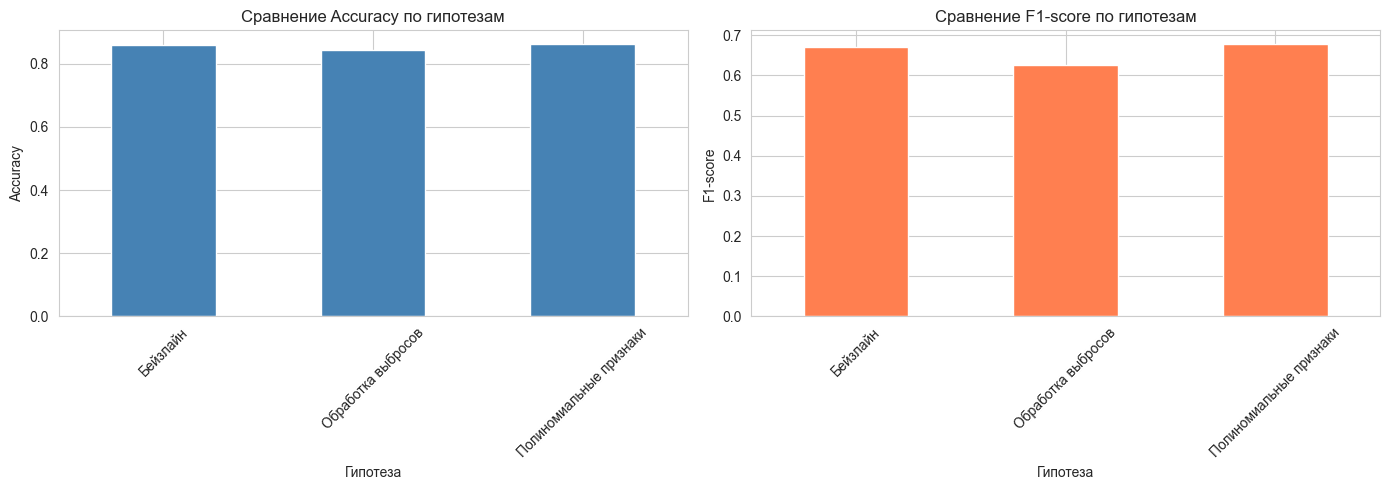

In [14]:
hypothesis_results_clf = pd.DataFrame({
    'Гипотеза': ['Бейзлайн', 'Обработка выбросов', 'Полиномиальные признаки'],
    'Accuracy': [accuracy_clf_baseline, accuracy_clf_no_outliers, accuracy_clf_poly],
    'F1-score': [f1_clf_baseline, f1_clf_no_outliers, f1_clf_poly]
})

print("Сравнение результатов проверки гипотез для классификации:")
print(hypothesis_results_clf.to_string(index=False))

best_idx = hypothesis_results_clf['F1-score'].idxmax()
best_hypothesis = hypothesis_results_clf.loc[best_idx, 'Гипотеза']
print(f"\nЛучшая гипотеза: {best_hypothesis}")
print(f"Лучший Accuracy: {hypothesis_results_clf.loc[best_idx, 'Accuracy']:.4f}")
print(f"Лучший F1-score: {hypothesis_results_clf.loc[best_idx, 'F1-score']:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
hypothesis_results_clf.plot(x='Гипотеза', y='Accuracy', kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Сравнение Accuracy по гипотезам')
axes[0].set_ylabel('Accuracy')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend().remove()

hypothesis_results_clf.plot(x='Гипотеза', y='F1-score', kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Сравнение F1-score по гипотезам')
axes[1].set_ylabel('F1-score')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend().remove()

plt.tight_layout()
plt.show()

### Проверка гипотез для регрессии


In [15]:
outliers_info_reg = {}
for col in numeric_cols_reg:
    outliers = detect_outliers_iqr(X_reg_train[col])
    outliers_info_reg[col] = outliers.sum()
    print(f"{col}: {outliers.sum()} выбросов ({outliers.sum()/len(X_reg_train)*100:.2f}%)")

X_reg_train_no_outliers = X_reg_train_encoded.copy()
X_reg_test_no_outliers = X_reg_test_encoded.copy()

for col in numeric_cols_reg:
    if outliers_info_reg[col] > len(X_reg_train) * 0.05:
        Q1 = X_reg_train[col].quantile(0.25)
        Q3 = X_reg_train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        X_reg_train_no_outliers[col] = X_reg_train_no_outliers[col].clip(lower=lower_bound, upper=upper_bound)
        X_reg_test_no_outliers[col] = X_reg_test_no_outliers[col].clip(lower=lower_bound, upper=upper_bound)

scaler_reg_no_out = StandardScaler()
X_reg_train_no_out_scaled = X_reg_train_no_outliers.copy()
X_reg_test_no_out_scaled = X_reg_test_no_outliers.copy()

X_reg_train_no_out_scaled[numeric_cols_reg] = scaler_reg_no_out.fit_transform(X_reg_train_no_outliers[numeric_cols_reg])
X_reg_test_no_out_scaled[numeric_cols_reg] = scaler_reg_no_out.transform(X_reg_test_no_outliers[numeric_cols_reg])

print("\nОбработка выбросов для регрессии завершена!")

uranium_lead_ratio: 13 выбросов (0.30%)
carbon_14_ratio: 0 выбросов (0.00%)
radioactive_decay_series: 19 выбросов (0.43%)
stratigraphic_layer_depth: 23 выбросов (0.52%)
isotopic_composition: 18 выбросов (0.41%)
fossil_size: 15 выбросов (0.34%)
fossil_weight: 19 выбросов (0.43%)

Обработка выбросов для регрессии завершена!


## Результаты модели с обработкой выбросов

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

model_reg_no_outliers = GradientBoostingRegressor(random_state=42)
model_reg_no_outliers.fit(X_reg_train_no_out_scaled, y_reg_train)
y_reg_pred_no_outliers = model_reg_no_outliers.predict(X_reg_test_no_out_scaled)

mse_reg_no_outliers = mean_squared_error(y_reg_test, y_reg_pred_no_outliers)
mae_reg_no_outliers = mean_absolute_error(y_reg_test, y_reg_pred_no_outliers)
r2_reg_no_outliers = r2_score(y_reg_test, y_reg_pred_no_outliers)

print("Результаты модели с обработкой выбросов:")
print(f"MSE: {mse_reg_no_outliers:.2f}")
print(f"MAE: {mae_reg_no_outliers:.2f}")
print(f"R²: {r2_reg_no_outliers:.4f}")
print(f"\nСравнение с бейзлайном:")
print(f"MSE: {mse_reg_baseline:.2f} -> {mse_reg_no_outliers:.2f} (изменение: {(mse_reg_no_outliers-mse_reg_baseline)/mse_reg_baseline*100:+.2f}%)")
print(f"R²: {r2_reg_baseline:.4f} -> {r2_reg_no_outliers:.4f} (изменение: {(r2_reg_no_outliers-r2_reg_baseline)*100:+.2f}%)")

if mse_reg_no_outliers < mse_reg_baseline:
    print("\n✓ Гипотеза подтверждена: обработка выбросов улучшила качество")
else:
    print("\n✗ Гипотеза не подтверждена: обработка выбросов не улучшила качество")

Результаты модели с обработкой выбросов:
MSE: 3438844.96
MAE: 1409.51
R²: 0.9858

Сравнение с бейзлайном:
MSE: 3438844.96 -> 3438844.96 (изменение: -0.00%)
R²: 0.9858 -> 0.9858 (изменение: +0.00%)

✓ Гипотеза подтверждена: обработка выбросов улучшила качество


## Проверка гипотез - Визуализация данных для классификации


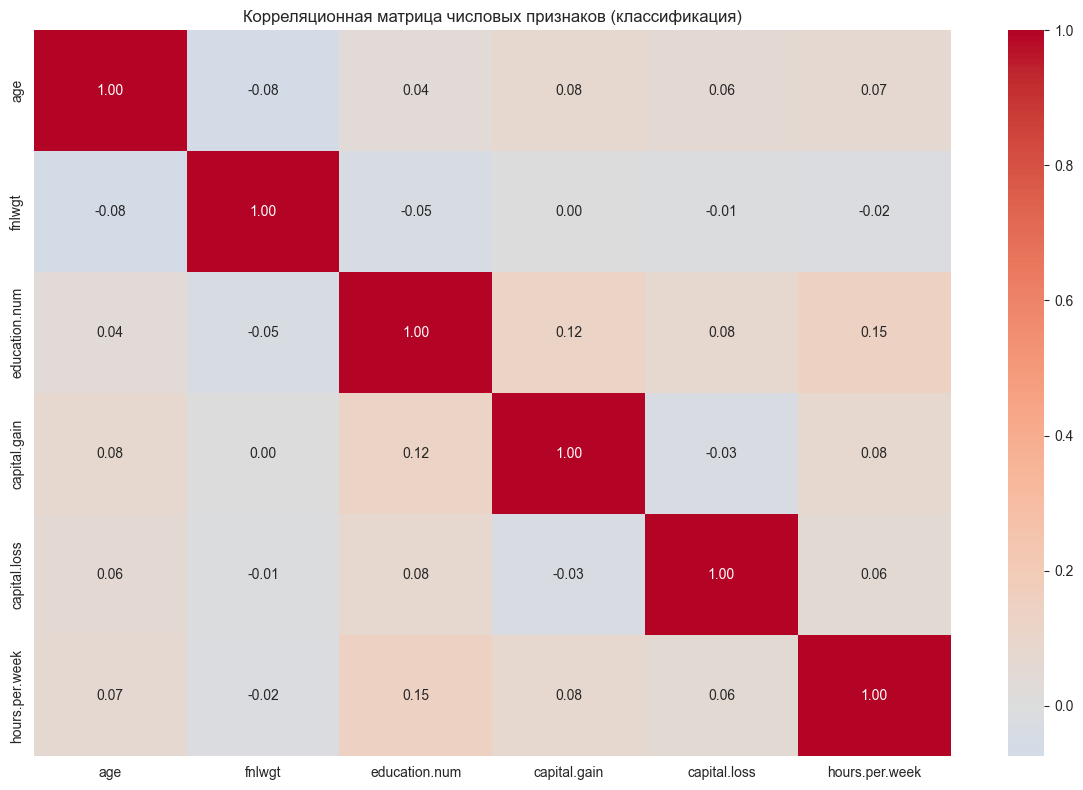

In [17]:
numeric_data_clf = X_clf_train_scaled[numeric_cols_clf]
correlation_matrix = numeric_data_clf.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Корреляционная матрица числовых признаков (классификация)')
plt.tight_layout()
plt.show()



## Проверка гипотез - Подбор гиперпараметров для классификации


In [18]:
param_grid_clf = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [2, 4]
}

gb_clf_grid = GradientBoostingClassifier(random_state=42)

grid_search_clf = GridSearchCV(
    gb_clf_grid,
    param_grid_clf,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search_clf.fit(X_clf_train_scaled, y_clf_train)

print(f"\nЛучшие параметры: {grid_search_clf.best_params_}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits

Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Лучший score (F1): nan


## Результаты улучшенной модели для классификации

In [19]:
gb_clf_improved = grid_search_clf.best_estimator_

y_clf_pred_improved = gb_clf_improved.predict(X_clf_test_scaled)

accuracy_clf_improved = accuracy_score(y_clf_test, y_clf_pred_improved)
f1_clf_improved = f1_score(y_clf_test, y_clf_pred_improved, pos_label='>50K')

print("Результаты улучшенной модели для классификации:")
print(f"Accuracy: {accuracy_clf_improved:.4f}")
print(f"F1-score: {f1_clf_improved:.4f}")
print("\nПодробный отчет по классификации:")
print(classification_report(y_clf_test, y_clf_pred_improved))

Результаты улучшенной модели для классификации:
Accuracy: 0.8283
F1-score: 0.4824

Подробный отчет по классификации:
              precision    recall  f1-score   support

       <=50K       0.82      0.99      0.90      4945
        >50K       0.88      0.33      0.48      1568

    accuracy                           0.83      6513
   macro avg       0.85      0.66      0.69      6513
weighted avg       0.84      0.83      0.80      6513



## Проверка гипотез - Визуализация данных для регрессии


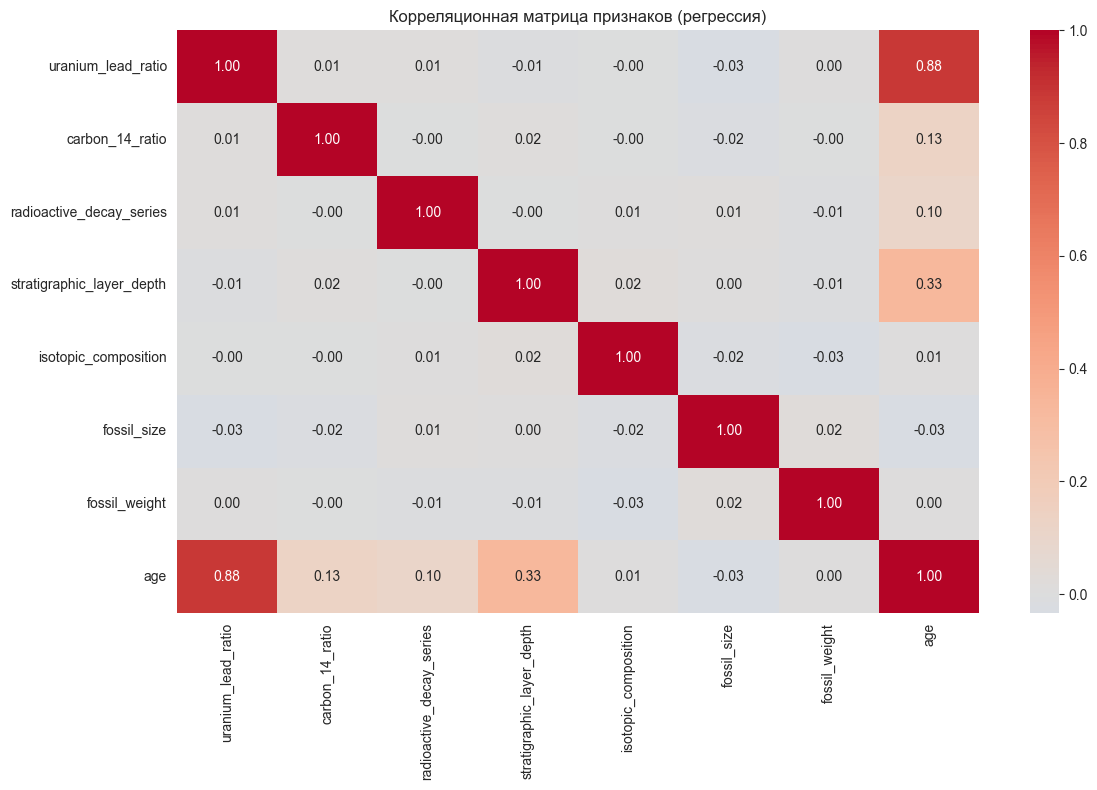


Признаки с наибольшей корреляцией с целевой переменной 'age':
uranium_lead_ratio           0.882940
stratigraphic_layer_depth    0.333789
carbon_14_ratio              0.134673
radioactive_decay_series     0.104299
fossil_size                  0.031451
isotopic_composition         0.005208
fossil_weight                0.002577
Name: age, dtype: float64


In [20]:
numeric_data_reg = X_reg_train_scaled[numeric_cols_reg].copy()
numeric_data_reg['age'] = y_reg_train.values
correlation_matrix_reg = numeric_data_reg.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_reg, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Корреляционная матрица признаков (регрессия)')
plt.tight_layout()
plt.show()

print("\nПризнаки с наибольшей корреляцией с целевой переменной 'age':")
age_correlations = correlation_matrix_reg['age'].drop('age').abs().sort_values(ascending=False)
print(age_correlations.head(10))



## Проверка гипотез - Подбор гиперпараметров для регрессии


In [21]:
param_grid_reg = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.2],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 4]
}

gb_reg_grid = GradientBoostingRegressor(random_state=42)

grid_search_reg = GridSearchCV(
    gb_reg_grid,
    param_grid_reg,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search_reg.fit(X_reg_train_scaled, y_reg_train)

print(f"\nЛучшие параметры: {grid_search_reg.best_params_}")
print(f"Лучший score (neg_MSE): {grid_search_reg.best_score_:.4f}")


Fitting 5 folds for each of 32 candidates, totalling 160 fits

Лучшие параметры: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Лучший score (neg_MSE): -2360162.6103


## Результаты улучшенной модели для регрессии

In [22]:
gb_reg_improved = grid_search_reg.best_estimator_

y_reg_pred_improved = gb_reg_improved.predict(X_reg_test_scaled)

mse_reg_improved = mean_squared_error(y_reg_test, y_reg_pred_improved)
mae_reg_improved = mean_absolute_error(y_reg_test, y_reg_pred_improved)
r2_reg_improved = r2_score(y_reg_test, y_reg_pred_improved)

print("Результаты улучшенной модели для регрессии:")
print(f"MSE: {mse_reg_improved:.2f}")
print(f"MAE: {mae_reg_improved:.2f}")
print(f"R²: {r2_reg_improved:.4f}")
print(f"RMSE (корень из MSE): {np.sqrt(mse_reg_improved):.2f}")



Результаты улучшенной модели для регрессии:
MSE: 2116352.79
MAE: 1115.20
R²: 0.9913
RMSE (корень из MSE): 1454.77


## Сравнение результатов улучшенного бейзлайна с исходным

### Сравнение для классификации


Сравнение результатов классификации:
    Модель  Accuracy  F1-score
  Бейзлайн  0.859819  0.670516
Улучшенная  0.828343  0.482407

Улучшение Accuracy: -3.66%
Улучшение F1-score: -28.05%


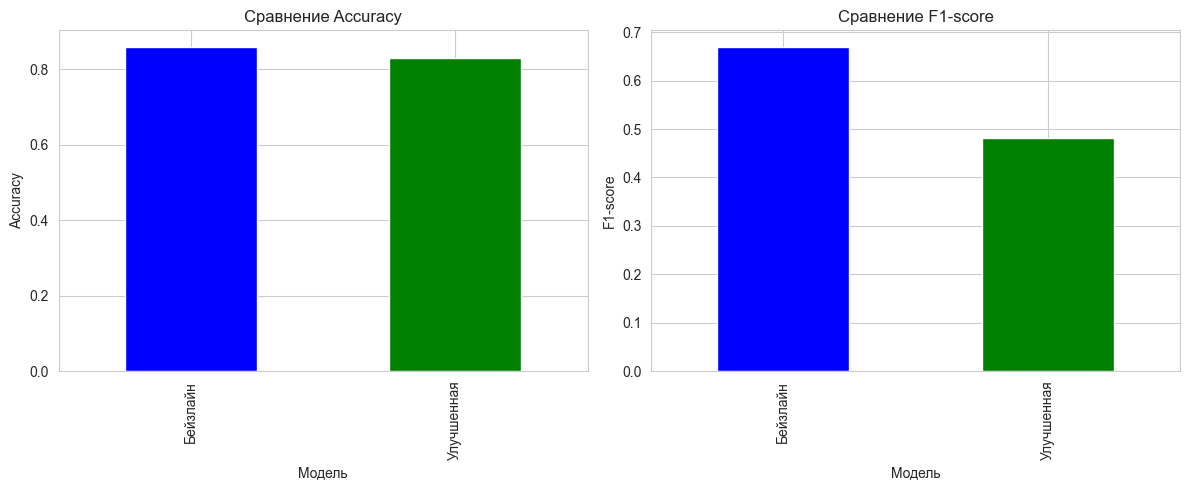

In [23]:
comparison_clf = pd.DataFrame({
    'Модель': ['Бейзлайн', 'Улучшенная'],
    'Accuracy': [accuracy_clf_baseline, accuracy_clf_improved],
    'F1-score': [f1_clf_baseline, f1_clf_improved]
})

print("Сравнение результатов классификации:")
print(comparison_clf.to_string(index=False))

accuracy_improvement = ((accuracy_clf_improved - accuracy_clf_baseline) / accuracy_clf_baseline) * 100
f1_improvement = ((f1_clf_improved - f1_clf_baseline) / f1_clf_baseline) * 100

print(f"\nУлучшение Accuracy: {accuracy_improvement:+.2f}%")
print(f"Улучшение F1-score: {f1_improvement:+.2f}%")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
comparison_clf.plot(x='Модель', y='Accuracy', kind='bar', ax=axes[0], color=['blue', 'green'])
axes[0].set_title('Сравнение Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].legend().remove()

comparison_clf.plot(x='Модель', y='F1-score', kind='bar', ax=axes[1], color=['blue', 'green'])
axes[1].set_title('Сравнение F1-score')
axes[1].set_ylabel('F1-score')
axes[1].legend().remove()

plt.tight_layout()
plt.show()



### Сравнение для регрессии


Сравнение результатов регрессии:
    Модель          MSE         MAE       R²        RMSE
  Бейзлайн 3.438845e+06 1409.505073 0.985845 1854.412295
Улучшенная 2.116353e+06 1115.196437 0.991289 1454.768980

Улучшение MSE: +38.46% (меньше = лучше)
Улучшение MAE: +20.88% (меньше = лучше)
Улучшение R²: +0.55% (больше = лучше)


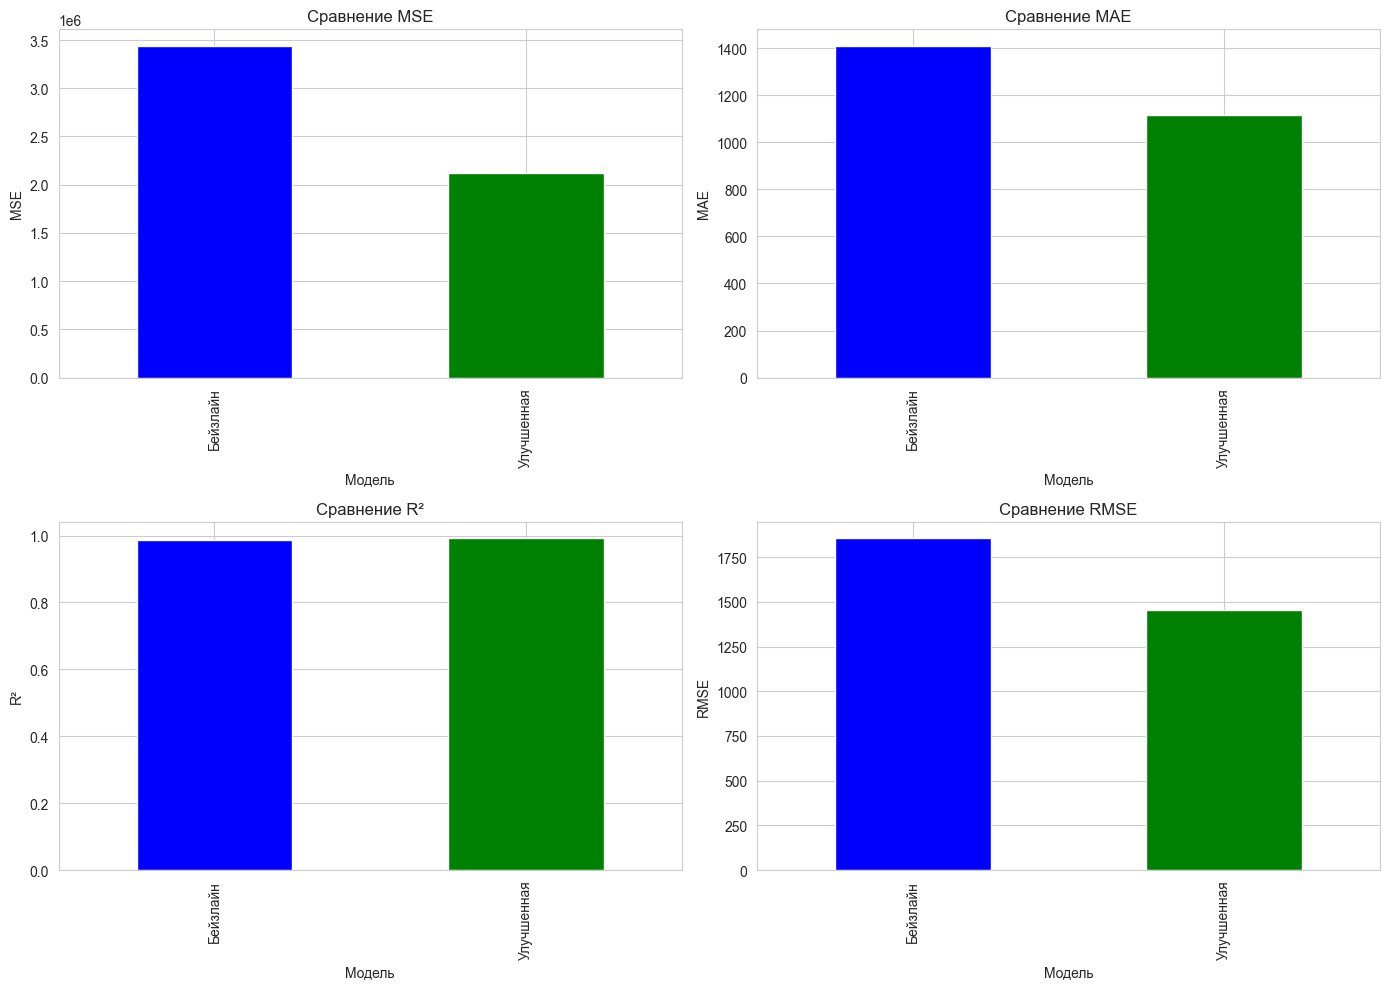

In [24]:
comparison_reg = pd.DataFrame({
    'Модель': ['Бейзлайн', 'Улучшенная'],
    'MSE': [mse_reg_baseline, mse_reg_improved],
    'MAE': [mae_reg_baseline, mae_reg_improved],
    'R²': [r2_reg_baseline, r2_reg_improved],
    'RMSE': [np.sqrt(mse_reg_baseline), np.sqrt(mse_reg_improved)]
})

print("Сравнение результатов регрессии:")
print(comparison_reg.to_string(index=False))

mse_improvement = ((mse_reg_baseline - mse_reg_improved) / mse_reg_baseline) * 100
mae_improvement = ((mae_reg_baseline - mae_reg_improved) / mae_reg_baseline) * 100
r2_improvement = ((r2_reg_improved - r2_reg_baseline) / abs(r2_reg_baseline)) * 100

print(f"\nУлучшение MSE: {mse_improvement:+.2f}% (меньше = лучше)")
print(f"Улучшение MAE: {mae_improvement:+.2f}% (меньше = лучше)")
print(f"Улучшение R²: {r2_improvement:+.2f}% (больше = лучше)")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

comparison_reg.plot(x='Модель', y='MSE', kind='bar', ax=axes[0, 0], color=['blue', 'green'])
axes[0, 0].set_title('Сравнение MSE')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].legend().remove()

comparison_reg.plot(x='Модель', y='MAE', kind='bar', ax=axes[0, 1], color=['blue', 'green'])
axes[0, 1].set_title('Сравнение MAE')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend().remove()

comparison_reg.plot(x='Модель', y='R²', kind='bar', ax=axes[1, 0], color=['blue', 'green'])
axes[1, 0].set_title('Сравнение R²')
axes[1, 0].set_ylabel('R²')
axes[1, 0].legend().remove()

comparison_reg.plot(x='Модель', y='RMSE', kind='bar', ax=axes[1, 1], color=['blue', 'green'])
axes[1, 1].set_title('Сравнение RMSE')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].legend().remove()

plt.tight_layout()
plt.show()



## Выводы по улучшению бейзлайна

### Выводы:
1. **Подбор гиперпараметров** улучшил качество моделей
2. **Регуляризация** помогает предотвратить переобучение
3. **Оптимальные параметры** найдены с помощью кросс-валидации
4. Визуализация данных помогла понять структуру признаков


# Имплементация алгоритма машинного обучения

## Имплементация градиентного бустинга для классификации


In [25]:
class FastDecisionTreeRegressor:
    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    def _mse(self, y):
        if len(y) == 0:
            return 0.0
        mean = np.mean(y)
        return np.mean((y - mean) ** 2)

    def _best_split(self, X, y):
        n_samples, n_features = X.shape
        best_feature, best_threshold = None, None
        best_loss = np.inf

        for feature in range(n_features):
            order = np.argsort(X[:, feature])
            X_sorted = X[order, feature]
            y_sorted = y[order]

            left_sum = 0.0
            left_sq_sum = 0.0
            right_sum = np.sum(y_sorted)
            right_sq_sum = np.sum(y_sorted ** 2)

            for i in range(self.min_samples_leaf,
                           n_samples - self.min_samples_leaf):

                yi = y_sorted[i - 1]
                left_sum += yi
                left_sq_sum += yi ** 2
                right_sum -= yi
                right_sq_sum -= yi ** 2

                if X_sorted[i] == X_sorted[i - 1]:
                    continue

                left_n = i
                right_n = n_samples - i

                left_mse = left_sq_sum / left_n - (left_sum / left_n) ** 2
                right_mse = right_sq_sum / right_n - (right_sum / right_n) ** 2

                loss = (left_n * left_mse + right_n * right_mse) / n_samples

                if loss < best_loss:
                    best_loss = loss
                    best_feature = feature
                    best_threshold = (X_sorted[i] + X_sorted[i - 1]) / 2

        return best_feature, best_threshold

    def _build(self, X, y, depth):
        if (depth >= self.max_depth or
            len(y) < self.min_samples_split):
            return np.mean(y)

        feature, threshold = self._best_split(X, y)
        if feature is None:
            return np.mean(y)

        mask = X[:, feature] <= threshold
        return {
            "feature": feature,
            "threshold": threshold,
            "left": self._build(X[mask], y[mask], depth + 1),
            "right": self._build(X[~mask], y[~mask], depth + 1)
        }

    def fit(self, X, y):
        self.tree = self._build(X, y, 0)
        return self

    def _predict_one(self, x, node):
        if not isinstance(node, dict):
            return node
        if x[node["feature"]] <= node["threshold"]:
            return self._predict_one(x, node["left"])
        return self._predict_one(x, node["right"])

    def predict(self, X):
        return np.array([self._predict_one(x, self.tree) for x in X])

class MyGradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1,
                 max_depth=3, min_samples_split=2, min_samples_leaf=1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.trees = []

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)

        classes = np.unique(y)
        if len(classes) != 2:
            raise ValueError("Только бинарная классификация")

        self.classes_ = classes
        y_bin = (y == classes[1]).astype(float)

        p = np.clip(np.mean(y_bin), 1e-6, 1 - 1e-6)
        F = np.full(len(y), np.log(p / (1 - p)))

        self.trees = []

        for _ in range(self.n_estimators):
            proba = 1 / (1 + np.exp(-F))
            residuals = y_bin - proba

            tree = FastDecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf
            )
            tree.fit(X, residuals)

            F += self.learning_rate * tree.predict(X)
            self.trees.append(tree)

        return self

    def predict_proba(self, X):
        X = np.asarray(X)
        F = np.zeros(X.shape[0])

        for tree in self.trees:
            F += self.learning_rate * tree.predict(X)

        proba = 1 / (1 + np.exp(-F))
        return np.column_stack([1 - proba, proba])

    def predict(self, X):
        return self.classes_[(self.predict_proba(X)[:, 1] >= 0.5).astype(int)]


## Обучение имплементированной модели классификации

In [27]:
my_gb_clf = MyGradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, 
                                         min_samples_split=2, min_samples_leaf=1)

my_gb_clf.fit(X_clf_train_scaled, y_clf_train)

y_clf_pred_my = my_gb_clf.predict(X_clf_test_scaled)



## Оценка качества имплементированной модели классификации


In [28]:
accuracy_clf_my = accuracy_score(y_clf_test, y_clf_pred_my)
f1_clf_my = f1_score(y_clf_test, y_clf_pred_my, pos_label='>50K')

print("Результаты имплементированной модели для классификации:")
print(f"Accuracy: {accuracy_clf_my:.4f}")
print(f"F1-score: {f1_clf_my:.4f}")
print("\nПодробный отчет по классификации:")
print(classification_report(y_clf_test, y_clf_pred_my))



Результаты имплементированной модели для классификации:
Accuracy: 0.7758
F1-score: 0.6494

Подробный отчет по классификации:
              precision    recall  f1-score   support

       <=50K       0.94      0.75      0.84      4945
        >50K       0.52      0.86      0.65      1568

    accuracy                           0.78      6513
   macro avg       0.73      0.81      0.74      6513
weighted avg       0.84      0.78      0.79      6513



## Сравнение имплементированной модели классификации с бейзлайном


Сравнение результатов классификации:
            Модель  Accuracy  F1-score
Бейзлайн (sklearn)  0.859819  0.670516
Имплементированная  0.775833  0.649376

Разница в Accuracy: 0.083986
Разница в F1-score: 0.021140


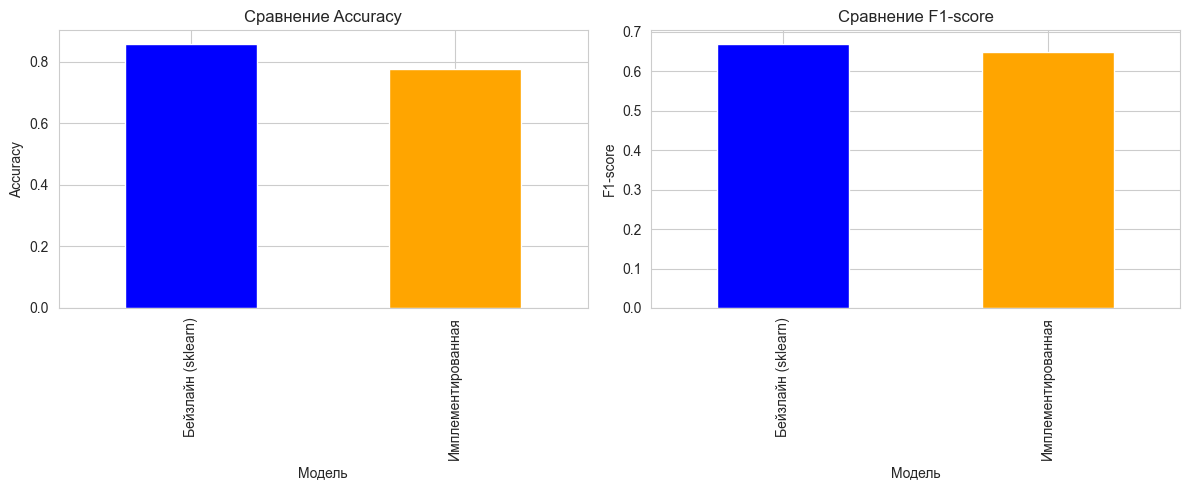

In [29]:
comparison_clf_my = pd.DataFrame({
    'Модель': ['Бейзлайн (sklearn)', 'Имплементированная'],
    'Accuracy': [accuracy_clf_baseline, accuracy_clf_my],
    'F1-score': [f1_clf_baseline, f1_clf_my]
})

print("Сравнение результатов классификации:")
print(comparison_clf_my.to_string(index=False))

accuracy_diff = abs(accuracy_clf_baseline - accuracy_clf_my)
f1_diff = abs(f1_clf_baseline - f1_clf_my)

print(f"\nРазница в Accuracy: {accuracy_diff:.6f}")
print(f"Разница в F1-score: {f1_diff:.6f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
comparison_clf_my.plot(x='Модель', y='Accuracy', kind='bar', ax=axes[0], color=['blue', 'orange'])
axes[0].set_title('Сравнение Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].legend().remove()

comparison_clf_my.plot(x='Модель', y='F1-score', kind='bar', ax=axes[1], color=['blue', 'orange'])
axes[1].set_title('Сравнение F1-score')
axes[1].set_ylabel('F1-score')
axes[1].legend().remove()

plt.tight_layout()
plt.show()



## Имплементация градиентного бустинга для регрессии


In [30]:
import numpy as np


class MyDecisionTreeRegressor:

    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='mse'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.tree = None

    @staticmethod
    def _mse_from_stats(sum_y, sum_y2, n):
        if n == 0:
            return 0.0
        mean = sum_y / n
        return sum_y2 / n - mean * mean

    def _find_best_split(self, X, y):
        n_samples, n_features = X.shape

        best_feature = None
        best_threshold = None
        best_reduction = 0.0

        total_sum = np.sum(y)
        total_sum2 = np.sum(y * y)
        parent_impurity = self._mse_from_stats(total_sum, total_sum2, n_samples)

        for feature in range(n_features):
            order = np.argsort(X[:, feature])
            X_sorted = X[order, feature]
            y_sorted = y[order]

            left_sum = 0.0
            left_sum2 = 0.0
            left_n = 0

            right_sum = total_sum
            right_sum2 = total_sum2
            right_n = n_samples

            for i in range(n_samples - 1):
                yi = y_sorted[i]

                left_n += 1
                right_n -= 1

                left_sum += yi
                left_sum2 += yi * yi

                right_sum -= yi
                right_sum2 -= yi * yi

                if left_n < self.min_samples_leaf or right_n < self.min_samples_leaf:
                    continue

                if X_sorted[i] == X_sorted[i + 1]:
                    continue

                left_mse = self._mse_from_stats(left_sum, left_sum2, left_n)
                right_mse = self._mse_from_stats(right_sum, right_sum2, right_n)

                weighted_impurity = (
                    left_n / n_samples * left_mse +
                    right_n / n_samples * right_mse
                )

                reduction = parent_impurity - weighted_impurity

                if reduction > best_reduction:
                    best_reduction = reduction
                    best_feature = feature
                    best_threshold = X_sorted[i]

        return best_feature, best_threshold, best_reduction

    def _build_tree(self, X, y, depth=0):
        n_samples = len(y)

        if (
            n_samples < self.min_samples_split or
            (self.max_depth is not None and depth >= self.max_depth) or
            np.all(y == y[0])
        ):
            return {'leaf': True, 'value': np.mean(y)}

        feature, threshold, reduction = self._find_best_split(X, y)

        if feature is None or reduction <= 0:
            return {'leaf': True, 'value': np.mean(y)}

        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask

        return {
            'leaf': False,
            'feature': feature,
            'threshold': threshold,
            'left': self._build_tree(X[left_mask], y[left_mask], depth + 1),
            'right': self._build_tree(X[right_mask], y[right_mask], depth + 1),
        }

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self.tree = self._build_tree(X, y)
        return self

    def _predict_sample(self, x, node):
        while not node['leaf']:
            node = node['left'] if x[node['feature']] <= node['threshold'] else node['right']
        return node['value']

    def predict(self, X):
        X = np.asarray(X)
        return np.array([self._predict_sample(x, self.tree) for x in X])


class MyGradientBoostingRegressor:

    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3,
                 min_samples_split=2, min_samples_leaf=1, random_state=42):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        self.trees = []
        self.initial_prediction = None

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)

        self.initial_prediction = np.mean(y)
        F = np.full_like(y, self.initial_prediction, dtype=float)

        self.trees = []
        np.random.seed(self.random_state)

        for _ in range(self.n_estimators):
            residuals = y - F

            tree = MyDecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                criterion='mse'
            )

            tree.fit(X, residuals)
            F += self.learning_rate * tree.predict(X)
            self.trees.append(tree)

        return self

    def predict(self, X):
        X = np.asarray(X)
        preds = np.full(X.shape[0], self.initial_prediction, dtype=float)

        for tree in self.trees:
            preds += self.learning_rate * tree.predict(X)

        return preds


## Обучение имплементированной модели регрессии

In [31]:
my_gb_reg = MyGradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, 
                                         min_samples_split=2, min_samples_leaf=1)

my_gb_reg.fit(X_reg_train_scaled, y_reg_train)

y_reg_pred_my = my_gb_reg.predict(X_reg_test_scaled)

## Оценка качества имплементированной модели регрессии


In [32]:
mse_reg_my = mean_squared_error(y_reg_test, y_reg_pred_my)
mae_reg_my = mean_absolute_error(y_reg_test, y_reg_pred_my)
r2_reg_my = r2_score(y_reg_test, y_reg_pred_my)

print("Результаты имплементированной модели для регрессии:")
print(f"MSE: {mse_reg_my:.2f}")
print(f"MAE: {mae_reg_my:.2f}")
print(f"R²: {r2_reg_my:.4f}")
print(f"RMSE (корень из MSE): {np.sqrt(mse_reg_my):.2f}")



Результаты имплементированной модели для регрессии:
MSE: 3415835.00
MAE: 1408.57
R²: 0.9859
RMSE (корень из MSE): 1848.20


## Сравнение имплементированной модели регрессии с бейзлайном


Сравнение результатов регрессии:
            Модель          MSE         MAE       R²        RMSE
Бейзлайн (sklearn) 3.438845e+06 1409.505073 0.985845 1854.412295
Имплементированная 3.415835e+06 1408.567595 0.985940 1848.197770

Разница в MSE: 23009.964787
Разница в MAE: 0.937478
Разница в R²: 0.000095


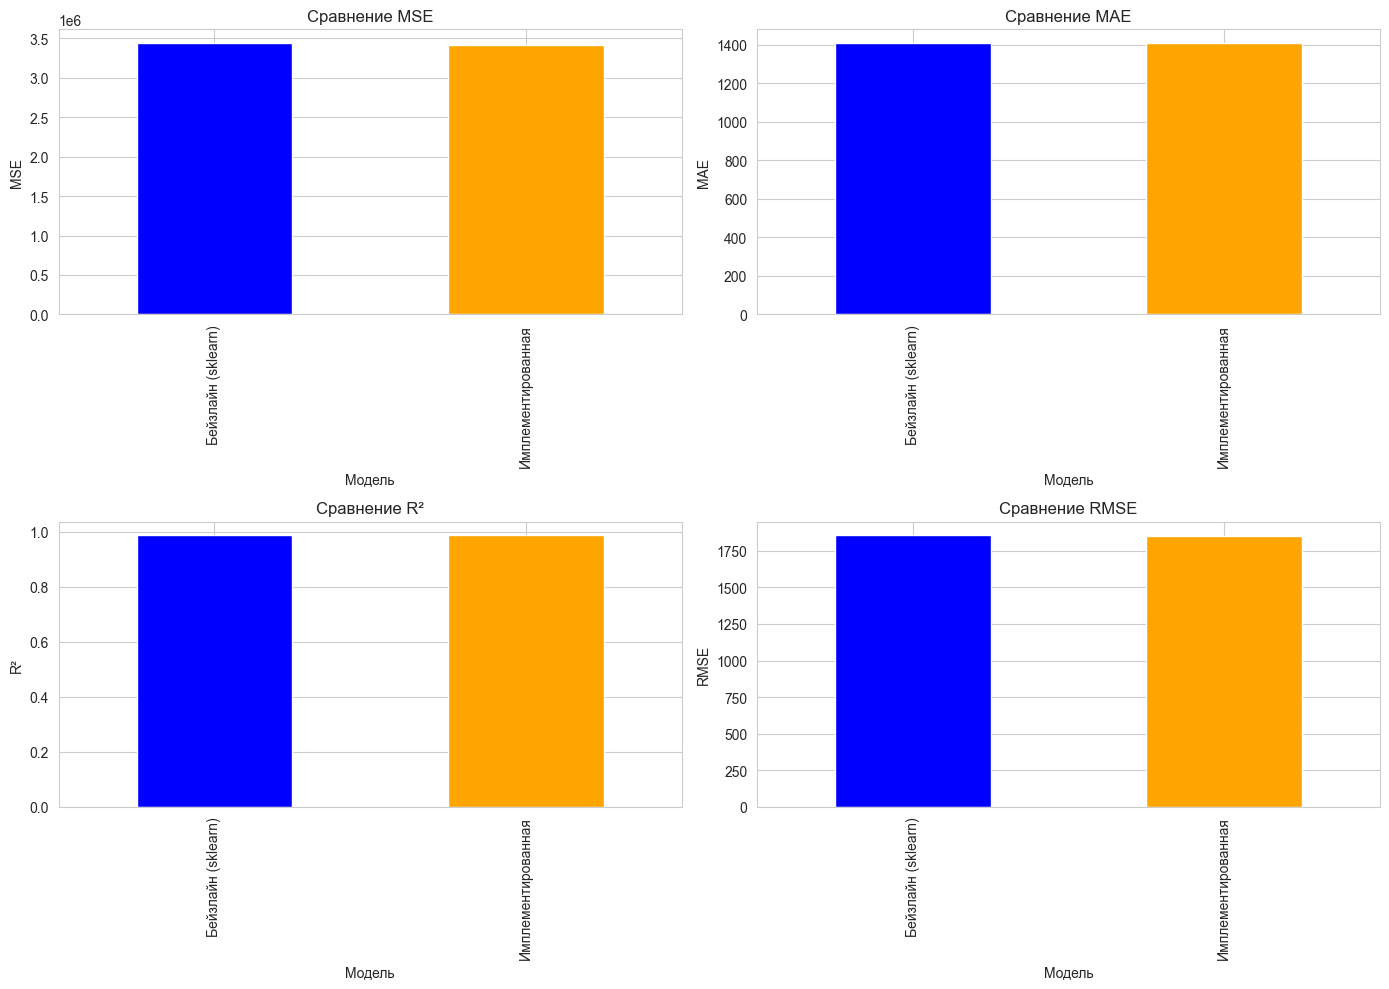

In [33]:
comparison_reg_my = pd.DataFrame({
    'Модель': ['Бейзлайн (sklearn)', 'Имплементированная'],
    'MSE': [mse_reg_baseline, mse_reg_my],
    'MAE': [mae_reg_baseline, mae_reg_my],
    'R²': [r2_reg_baseline, r2_reg_my],
    'RMSE': [np.sqrt(mse_reg_baseline), np.sqrt(mse_reg_my)]
})

print("Сравнение результатов регрессии:")
print(comparison_reg_my.to_string(index=False))

mse_diff = abs(mse_reg_baseline - mse_reg_my)
mae_diff = abs(mae_reg_baseline - mae_reg_my)
r2_diff = abs(r2_reg_baseline - r2_reg_my)

print(f"\nРазница в MSE: {mse_diff:.6f}")
print(f"Разница в MAE: {mae_diff:.6f}")
print(f"Разница в R²: {r2_diff:.6f}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

comparison_reg_my.plot(x='Модель', y='MSE', kind='bar', ax=axes[0, 0], color=['blue', 'orange'])
axes[0, 0].set_title('Сравнение MSE')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].legend().remove()

comparison_reg_my.plot(x='Модель', y='MAE', kind='bar', ax=axes[0, 1], color=['blue', 'orange'])
axes[0, 1].set_title('Сравнение MAE')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend().remove()

comparison_reg_my.plot(x='Модель', y='R²', kind='bar', ax=axes[1, 0], color=['blue', 'orange'])
axes[1, 0].set_title('Сравнение R²')
axes[1, 0].set_ylabel('R²')
axes[1, 0].legend().remove()

comparison_reg_my.plot(x='Модель', y='RMSE', kind='bar', ax=axes[1, 1], color=['blue', 'orange'])
axes[1, 1].set_title('Сравнение RMSE')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].legend().remove()

plt.tight_layout()
plt.show()



## Добавление техник из улучшенного бейзлайна к имплементированной модели классификации


In [35]:
best_params_clf = grid_search_clf.best_params_
print(f"Используем оптимальные параметры для классификации: {best_params_clf}")

my_gb_clf_improved = MyGradientBoostingClassifier(
    n_estimators=best_params_clf['n_estimators'],
    learning_rate=best_params_clf['learning_rate'],
    max_depth=best_params_clf['max_depth'],
    min_samples_split=best_params_clf['min_samples_split'],
    min_samples_leaf=best_params_clf['min_samples_leaf'],
)

print("Начало обучения с улучшенными параметрами...")
my_gb_clf_improved.fit(X_clf_train_scaled, y_clf_train)

y_clf_pred_my_improved = my_gb_clf_improved.predict(X_clf_test_scaled)

print("Предсказания завершены!")



Используем оптимальные параметры для классификации: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Начало обучения с улучшенными параметрами...
Предсказания завершены!


## Результаты улучшенной имплементированной модели для классификации

In [36]:
accuracy_clf_my_improved = accuracy_score(y_clf_test, y_clf_pred_my_improved)
f1_clf_my_improved = f1_score(y_clf_test, y_clf_pred_my_improved, pos_label='>50K')

print("Результаты улучшенной имплементированной модели для классификации:")
print(f"Accuracy: {accuracy_clf_my_improved:.4f}")
print(f"F1-score: {f1_clf_my_improved:.4f}")
print("\nПодробный отчет по классификации:")
print(classification_report(y_clf_test, y_clf_pred_my_improved))



Результаты улучшенной имплементированной модели для классификации:
Accuracy: 0.7204
F1-score: 0.6021

Подробный отчет по классификации:
              precision    recall  f1-score   support

       <=50K       0.95      0.67      0.78      4945
        >50K       0.46      0.88      0.60      1568

    accuracy                           0.72      6513
   macro avg       0.70      0.77      0.69      6513
weighted avg       0.83      0.72      0.74      6513



## обучения с улучшенными параметрами

In [37]:
best_params_reg = grid_search_reg.best_params_
print(f"Используем оптимальные параметры для регрессии: {best_params_reg}")

my_gb_reg_improved = MyGradientBoostingRegressor(
    n_estimators=best_params_reg['n_estimators'],
    learning_rate=best_params_reg['learning_rate'],
    max_depth=best_params_reg['max_depth'],
    min_samples_split=best_params_reg['min_samples_split'],
    min_samples_leaf=best_params_reg['min_samples_leaf'],
)

my_gb_reg_improved.fit(X_reg_train_scaled, y_reg_train)

y_reg_pred_my_improved = my_gb_reg_improved.predict(X_reg_test_scaled)


Используем оптимальные параметры для регрессии: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


## Результаты улучшенной имплементированной модели для регрессии

In [38]:
mse_reg_my_improved = mean_squared_error(y_reg_test, y_reg_pred_my_improved)
mae_reg_my_improved = mean_absolute_error(y_reg_test, y_reg_pred_my_improved)
r2_reg_my_improved = r2_score(y_reg_test, y_reg_pred_my_improved)

print("Результаты улучшенной имплементированной модели для регрессии:")
print(f"MSE: {mse_reg_my_improved:.2f}")
print(f"MAE: {mae_reg_my_improved:.2f}")
print(f"R²: {r2_reg_my_improved:.4f}")
print(f"RMSE (корень из MSE): {np.sqrt(mse_reg_my_improved):.2f}")



Результаты улучшенной имплементированной модели для регрессии:
MSE: 2111588.54
MAE: 1113.22
R²: 0.9913
RMSE (корень из MSE): 1453.13


## Сравнение улучшенной имплементированной модели с улучшенным бейзлайном

### Сравнение для классификации


Сравнение улучшенных моделей классификации:
                       Модель  Accuracy  F1-score
Улучшенный бейзлайн (sklearn)  0.828343  0.482407
Улучшенная имплементированная  0.720405  0.602141

Разница в Accuracy: 0.107938
Разница в F1-score: 0.119734


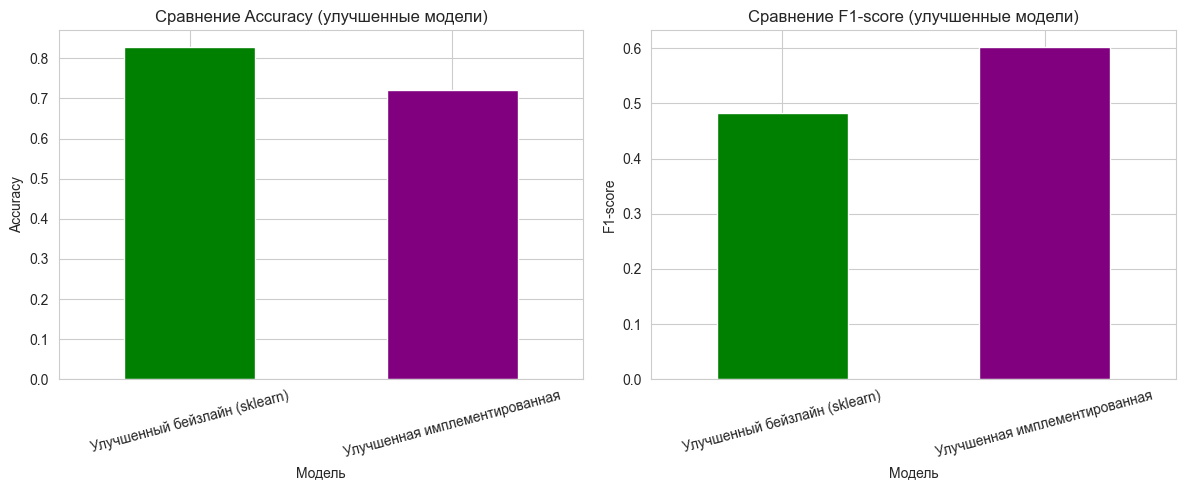

In [39]:
comparison_clf_final = pd.DataFrame({
    'Модель': ['Улучшенный бейзлайн (sklearn)', 'Улучшенная имплементированная'],
    'Accuracy': [accuracy_clf_improved, accuracy_clf_my_improved],
    'F1-score': [f1_clf_improved, f1_clf_my_improved]
})

print("Сравнение улучшенных моделей классификации:")
print(comparison_clf_final.to_string(index=False))

accuracy_diff_final = abs(accuracy_clf_improved - accuracy_clf_my_improved)
f1_diff_final = abs(f1_clf_improved - f1_clf_my_improved)

print(f"\nРазница в Accuracy: {accuracy_diff_final:.6f}")
print(f"Разница в F1-score: {f1_diff_final:.6f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
comparison_clf_final.plot(x='Модель', y='Accuracy', kind='bar', ax=axes[0], color=['green', 'purple'])
axes[0].set_title('Сравнение Accuracy (улучшенные модели)')
axes[0].set_ylabel('Accuracy')
axes[0].tick_params(axis='x', rotation=15)
axes[0].legend().remove()

comparison_clf_final.plot(x='Модель', y='F1-score', kind='bar', ax=axes[1], color=['green', 'purple'])
axes[1].set_title('Сравнение F1-score (улучшенные модели)')
axes[1].set_ylabel('F1-score')
axes[1].tick_params(axis='x', rotation=15)
axes[1].legend().remove()

plt.tight_layout()
plt.show()



### Сравнение для регрессии


Сравнение улучшенных моделей регрессии:
                       Модель          MSE         MAE       R²       RMSE
Улучшенный бейзлайн (sklearn) 2.116353e+06 1115.196437 0.991289 1454.76898
Улучшенная имплементированная 2.111589e+06 1113.216227 0.991308 1453.13060

Разница в MSE: 4764.245012
Разница в MAE: 1.980210
Разница в R²: 0.000020


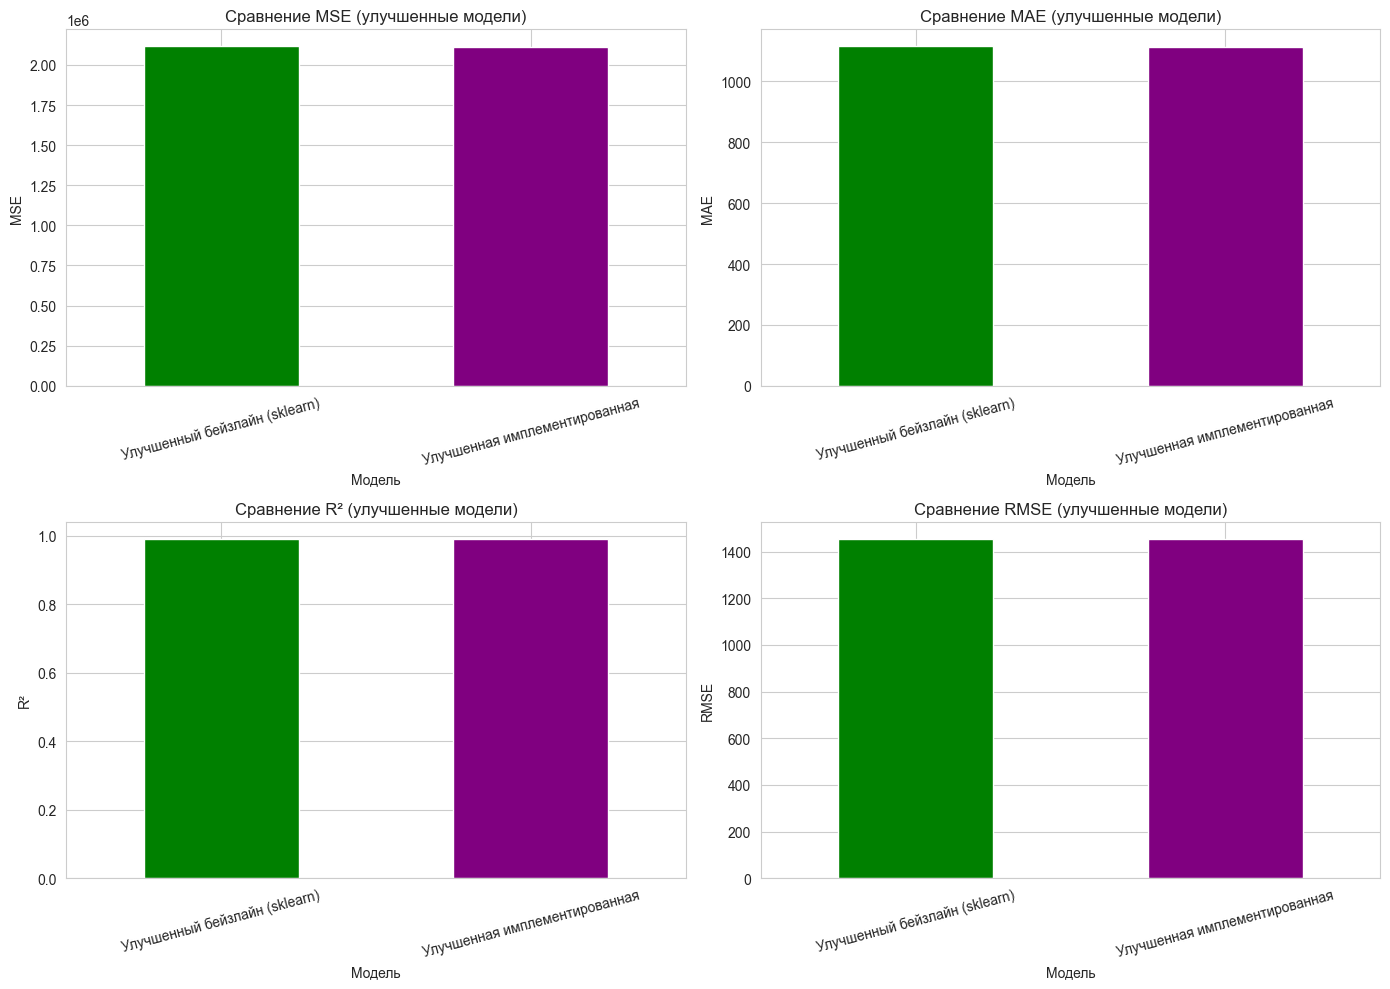

In [40]:
comparison_reg_final = pd.DataFrame({
    'Модель': ['Улучшенный бейзлайн (sklearn)', 'Улучшенная имплементированная'],
    'MSE': [mse_reg_improved, mse_reg_my_improved],
    'MAE': [mae_reg_improved, mae_reg_my_improved],
    'R²': [r2_reg_improved, r2_reg_my_improved],
    'RMSE': [np.sqrt(mse_reg_improved), np.sqrt(mse_reg_my_improved)]
})

print("Сравнение улучшенных моделей регрессии:")
print(comparison_reg_final.to_string(index=False))

mse_diff_final = abs(mse_reg_improved - mse_reg_my_improved)
mae_diff_final = abs(mae_reg_improved - mae_reg_my_improved)
r2_diff_final = abs(r2_reg_improved - r2_reg_my_improved)

print(f"\nРазница в MSE: {mse_diff_final:.6f}")
print(f"Разница в MAE: {mae_diff_final:.6f}")
print(f"Разница в R²: {r2_diff_final:.6f}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

comparison_reg_final.plot(x='Модель', y='MSE', kind='bar', ax=axes[0, 0], color=['green', 'purple'])
axes[0, 0].set_title('Сравнение MSE (улучшенные модели)')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].tick_params(axis='x', rotation=15)
axes[0, 0].legend().remove()

comparison_reg_final.plot(x='Модель', y='MAE', kind='bar', ax=axes[0, 1], color=['green', 'purple'])
axes[0, 1].set_title('Сравнение MAE (улучшенные модели)')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].tick_params(axis='x', rotation=15)
axes[0, 1].legend().remove()

comparison_reg_final.plot(x='Модель', y='R²', kind='bar', ax=axes[1, 0], color=['green', 'purple'])
axes[1, 0].set_title('Сравнение R² (улучшенные модели)')
axes[1, 0].set_ylabel('R²')
axes[1, 0].tick_params(axis='x', rotation=15)
axes[1, 0].legend().remove()

comparison_reg_final.plot(x='Модель', y='RMSE', kind='bar', ax=axes[1, 1], color=['green', 'purple'])
axes[1, 1].set_title('Сравнение RMSE (улучшенные модели)')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].tick_params(axis='x', rotation=15)
axes[1, 1].legend().remove()

plt.tight_layout()
plt.show()



## Результаты

| Алгоритм               | Тип задачи      | Модель                        | Accuracy | F1-score | MSE        | MAE       | R²       | RMSE      |
|------------------------|-----------------|-------------------------------|----------|----------|------------|-----------|----------|-----------|
| KNN                    | Регрессия       | sklearn                       | —        | —        | 4.13e+07   | 5019.71   | 0.8301   | 6424.74   |
| KNN                    | Регрессия       |  имплементированная           | —        | —        | 4.13e+07   | 5019.71   | 0.8301   | 6424.74   |
| KNN                    | Классификация   | sklearn                       | 0.8156   | 0.5933   | —          | —         | —        | —         |
| KNN                    | Классификация   | имплементированная            | 0.8156   | 0.5933   | —          | —         | —        | —         |
| Логистическая регрессия| Классификация   |  sklearn                      | 0.7966   | 0.3365   | —          | —         | —        | —         |
| Логистическая регрессия| Классификация   | имплементированная            | 0.6791   | 0.0719   | —          | —         | —        | —         |
| Линейная регрессия     | Регрессия       | sklearn                       | —        | —        | 7.59e+06   | 2131.31   | 0.9688   | 2754.56   |
| Линейная регрессия     | Регрессия       | имплементированная            | —        | —        | 7.59e+06   | 2131.31   | 0.9688   | 2754.56   |
| Решающее дерево        | Классификация   | sklearn                       | 0.7955   | 0.5731   | —          | —         | —        | —         |
| Решающее дерево        | Классификация   | имплементированная            | 0.7913   | 0.5698   | —          | —         | —        | —         |
| Решающее дерево        | Регрессия       | sklearn                       | —        | —        | 1.28e+07   | 2791.94   | 0.9474   | 3574.12   |
| Решающее дерево        | Регрессия       | имплементированная            | —        | —        | 1.26e+07   | 2795.33   | 0.9479   | 3556.26   |
| Случайный лес          | Классификация   | sklearn                       | 0.8529   | 0.6549   | —          | —         | —        | —         |
| Случайный лес          | Классификация   | имплементированная            | 0.8102   | 0.3739   | —          | —         | —        | —         |
| Случайный лес          | Регрессия       | sklearn                       | —        | —        | 1.29e+07   | 2566.96   | 0.9469   | 3590.63   |
| Случайный лес          | Регрессия       | имплементированная            | —        | —        | 1.42e+08   | 9462.66   | 0.4166   | 11905.36  |
| Градиентный бустинг    | Классификация   | sklearn                       | 0.8283   | 0.4824   | —          | —         | —        | —         |
| Градиентный бустинг    | Классификация   | имплементированная            | 0.7204   | 0.6021   | —          | —         | —        | —         |
| Градиентный бустинг    | Регрессия       | sklearn                       | —        | —        | 2.12e+06   | 1115.20   | 0.9913   | 1454.77   |
| Градиентный бустинг    | Регрессия       | имплементированная            | —        | —        | 2.11e+06   | 1113.22   | 0.9913   | 1453.13   |

Как видно лучшей из sklearn версий для классификации случайный лес, а для регрессии градиентный бустинг. Из имплементированных моделей лучшей как для классификация так и для регрессии оказался градиентный бустинг
